# Data generator for kaggle google_doodles competition.

https://www.kaggle.com/c/quickdraw-doodle-recognition

Can take advantage of many physical cores. Provides ~0.75 per physical core speedup.

This means that on kaggle kernels, it's slower - that's because in kaggle kernels, even though it says it has two cpus, it actually only has a single physical cpu, and two logical ones. But it speeds up on machines with more. Important, because on a single core, to iterate all of the available data takes ~2.5 hours. 

There exist 340 csv files, each row containing stroke information for drawings (doodles). In sum there are ~50M samples, and we want to turn them into batches of images and labels (one-hots) that we can feed as a generator to model fit_generator-type functions.

You can do:

    fnames = TRAIN_FILE_NAMES[:nclasses]
    bfg = mp_data_generator(cores, fnames, nclasses, 
                            nrows=nclasses*rowsperclass, 
                            start_at=2_000, 
                            chunk_size=2_000, 
                            block_size=1_000, 
                            batch_size=512, 
                            image_size=64, 
                            line_width=6, 
                            elide_not_recognized=True,
                            forever=True)
                            
... and `bfg` can then iterate through data x and y pairs, where x's are numpy images and y's are 1-hots. Suitable for keras or other model training.

In [1]:
import numpy as np
import pandas as pd
import glob
import ast
import os
import cv2
import math
import json
import time
import matplotlib.pyplot as plt
import collections
from multiprocessing import Process, Queue
from timeit import default_timer as timer
from pathlib import Path

## Create global variables we need, get sample counts for data

In [2]:
BASE_DIR         = '/storage'
INPUT_DIR        = '/storage/google_doodles/train'
CACHE_DIR        = '/storage/cache'
DATA_SIZES_FN    = '/storage/cache/data_sizes.json'
COLUMNS          = ['countrycode', 'drawing', 'key_id', 'recognized', 'timestamp', 'word']
TRAIN_FILE_NAMES = list(sorted(glob.glob(os.path.join(INPUT_DIR, '*.csv'))))
ALL_WORDS        = list(sorted([Path(f).stem.replace(' ', '_') for f in TRAIN_FILE_NAMES]))
WORDS_TO_INDEXES = { word: index for index, word in enumerate(ALL_WORDS) }
INDEXES_TO_WORDS = { i: word for i, word in enumerate(ALL_WORDS) }
NCLASSES         = len(ALL_WORDS)


if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)

    
def class_name_from_file_name(fname):
    return Path(fname).stem.replace(' ', '_')

def file_name_from_class_name(cname):
    fname = cname.replace('_', ' ')
    return os.path.join(INPUT_DIR, f'{fname}.csv')

def num_lines_in_file(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i

def get_total_samples_per_file():
    if os.path.exists(DATA_SIZES_FN):
        with open(DATA_SIZES_FN) as f:
            return json.load(f)
    else:
        data = { file: num_lines_in_file(file) for file in TRAIN_FILE_NAMES }
        with open(DATA_SIZES_FN, 'w') as outfile:
            json.dump(data, outfile)
        return data
    
    
DATA_SIZES = get_total_samples_per_file()
TOTAL_SAMPLES = sum([s for s in DATA_SIZES.values()])


def get_total_samples(num_classes=NCLASSES):
    return sum([DATA_SIZES[s] for s in TRAIN_FILE_NAMES[0:num_classes]])

print(f'NCLASSES:{NCLASSES}, TOTAL_SAMPLES:{TOTAL_SAMPLES}, SAMPLES(1):{get_total_samples(1)}, SAMPLES(2):{get_total_samples(2)}, SAMPLES({NCLASSES}):{get_total_samples(NCLASSES)}')

NCLASSES:340, TOTAL_SAMPLES:49707579, SAMPLES(1):134801, SAMPLES(2):327816, SAMPLES(340):49707579


## Data generation functions

One giant cell, so's to make copy-n-paste easy. You'll need this and the above 2 cells to make it work.

### Generator madness!
At the end, we'll have a data generator that can step through all data file in parallel, creating x/y batch pairs of 
    * x <images>  : (batch_size, image_size, image_size, 1)
    * y <onehots> : (batch_size, nclasses)

In [3]:
# create a generator that iterates over the data file in chunks, processing it a bit along the way.

def df_generator(filename, startat, chunk_size, elide_not_recognized):
    iterator = pd.read_csv(filename, chunksize=chunk_size, names=COLUMNS, skiprows=startat+1, parse_dates=['timestamp'])
    for chunk in iterator:
        df = chunk[chunk['recognized'] == True].copy() if elide_not_recognized else chunk
        df['word'] = df['word'].apply(lambda word: word.replace(' ', '_'))
        df['word_index'] = df['word'].apply(lambda word: WORDS_TO_INDEXES[word])
        df['drawing'] = df['drawing'].apply(json.loads)
        yield df

        

# generator madness!

def gen_forever(generator_constructor):
    while True:
        generator = generator_constructor()
        for v in generator:
            yield v
            
def df_gen_resequenced(df_gen, block_size):
    acc_df = None
    for df in df_gen:
        acc_df = df if (acc_df is None) else pd.concat([acc_df, df])
        if acc_df.shape[0] >= block_size:
            ret_df = acc_df[0:block_size]
            acc_df = acc_df[block_size:]
            yield ret_df
    yield acc_df
    
def df_gen_sampled(df_gen):
    return (df.sample(frac=1) for df in df_gen)
        
def df_gen_max(df_gen, max_rows):
    rows = 0
    for df in df_gen:
        rows_to_return = min(df.shape[0], max_rows - rows)
        if rows_to_return <= 0:
            break
        else:
            v = df[:rows_to_return]
            rows += v.shape[0]
            yield v
            
def df_gen_sum(df_gens):
    return (pd.concat(class_dfs).reset_index(drop=True) for class_dfs in zip(*df_gens))


        
# higher-level generators - combine df_generator with the madness above...

def df_file_generator_notforever(fname, nrows, start_at, chunk_size, block_size, elide_not_recognized):
    # well - it still uses 'forever' in that it repeats, but capped at the max, 
    # which can be > # samples (in which case it shall repeat)
    df_gen_const = lambda: df_generator(fname, start_at, chunk_size, elide_not_recognized)
    return df_gen_max(df_gen_resequenced(gen_forever(df_gen_const), block_size), nrows)
            
def df_file_generator_forever(fname, nrows, start_at, chunk_size, block_size, elide_not_recognized):
    # this is is truly forever - it repeats up to the max, over and over
    def generator_constructor():
        return df_file_generator_notforever(fname, nrows, start_at, chunk_size, block_size, elide_not_recognized)
    return gen_forever(generator_constructor)

def df_file_generator(fname, nrows, start_at, chunk_size, block_size, elide_not_recognized, forever):
    if forever:
        return df_file_generator_forever(fname, nrows, start_at, chunk_size, block_size, elide_not_recognized)
    else:
        return df_file_generator_notforever(fname, nrows, start_at, chunk_size, block_size, elide_not_recognized)

    
# The big kahuna! So far, anyway...

def df_files_generator_uniform(fnames=TRAIN_FILE_NAMES, 
                               nclasses=NCLASSES, 
                               nrows=3_000, 
                               start_at=2_000, 
                               chunk_size=2_000, 
                               block_size=1_000, 
                               elide_not_recognized=True, 
                               forever=False):
    '''generate over a set of files by chunk
    
    Args:
        fnames ([str]): [filename]
        nclasses (int): number of classes in total in use
        nrows (int): number of rows to return in total
        start_at (int): can be used to skip rows in each file, for example for validation/training data set
        chunk_size (int): number of rows to read in each file in parallel
        block_size (int): number of rows to yield from each file (probably < chunk_size, because it uses lots of memory and cpu)
        elide_not_recognized (bool): whether we should skip the not_recognized rows
        forever (bool): whether this should generate forever
    '''
    df_gens = [df_file_generator(fname, nrows // nclasses, start_at, chunk_size, block_size, elide_not_recognized, forever) for fname in fnames]
    return df_gen_resequenced(df_gen_sampled(df_gen_sum(df_gens)), block_size)

# todo... not tested...
def df_files_generator_proportional(fnames, nclasses, nrows, start_at, chunk_size, block_size, elide_not_recognized, forever):
    datasizesum = sum([DATA_SIZES[fname] for fname in fnames])
    df_gens = [df_file_generator(fname, nrows, start_at, chunk_size, int(block_size * DATA_SIZES[fname] / datasizesum), elide_not_recognized, forever) for fname in fnames]
    return df_gen_resequenced(df_gen_sampled(df_gen_sum(df_gens)), block_size)


# The above gives us generators over processed rows of the dataframes(for files), without using too much memory.


# Now the code to map from dataframe rows to images and one-hots:

def data_draw_cv2(raw_strokes, size=256, linewidth=6, time_color=True):
    img = np.zeros((256, 256), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), 
                         (stroke[0][i + 1], stroke[1][i + 1]), color, linewidth)
    if size != 256:
        return cv2.resize(img, (size, size))
    else:
        return img
    
def data_one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

def data_generate_batch_from_df(df, num_classes, batch_size, image_size, line_width):
    for i in range(0, df.shape[0], batch_size):
        y = data_one_hot(df['word_index'][i:i+batch_size].values, num_classes)
        
        x = np.zeros((y.shape[0], image_size, image_size))
        for j, raw_strokes in enumerate(df.drawing[i:i+batch_size]):
            x[j] = data_draw_cv2(raw_strokes, size=image_size, linewidth=line_width)
        x = x / 255.
        x = x.reshape((y.shape[0], image_size, image_size, 1)).astype(np.float32)
        
        yield (x, y)
        
def data_generator(df_generator, num_classes, batch_size, image_size, line_width):        
    for df in df_generator:
        for x, y in data_generate_batch_from_df(df, num_classes, batch_size, image_size, line_width):
            yield x, y
            
def unify_df_to_data(name, fnames, nrows, nclasses, start_at, chunk_size, block_size, batch_size, image_size, line_width, elide_not_recognized, forever):
    df_gen = df_files_generator_uniform(fnames, nclasses, nrows, start_at, chunk_size, block_size, elide_not_recognized, forever)
    return data_generator(df_gen, nclasses, batch_size, image_size, line_width)


# But wait! This will be cool: multiprocessing generators!

def mp_process_generator_const(name, fnames, nrows, nclasses, start_at, chunk_size, block_size, batch_size, image_size, line_width, elide_not_recognized, forever):
    '''returns a generator constructor that returns a generator that yields data, 
       in batches, for collection of classes (filenames)'''
    
    def generator(outputQueue):
        g = unify_df_to_data(name, fnames, nrows, nclasses, start_at, chunk_size, block_size, batch_size, image_size, line_width, elide_not_recognized, forever)
        for v in g:
            outputQueue.put(v)
        outputQueue.put(None)
        
    return generator


def mp_generate_over_outputqueues(outputQueues, batch_size):
    '''generates, in parallel, by reading from outputQueues
       Shuffles and resequences along the way.'''
    
    done = False
    while not done:
        results = [oq.get() for oq in outputQueues]
        # If any fail, just bail
        done = any(res is None for res in results)
        if not done:
            # collect the data (images and one-hots), and shuffle the same way
            images = np.concatenate([res[0] for res in results], axis=0)
            onehots = np.concatenate([res[1] for res in results], axis=0)
            s = np.arange(0, images.shape[0], 1)
            np.random.shuffle(s)
            images_shuffled = images[s]
            onehots_shuffled = onehots[s]
            
            # resequence again - use the same batch size I guess...
            for i in range(0, images_shuffled.shape[0], batch_size):
                end = i + batch_size
                yield (images_shuffled[i:end], onehots_shuffled[i:end])
                
# got lazy...
def data_generator_resequenced(np_gen, batch_size):
    acc_arr0 = None
    acc_arr1 = None
    for arr0, arr1 in np_gen:
        acc_arr0 = arr0 if (acc_arr0 is None) else np.concatenate([acc_arr0, arr0])
        acc_arr1 = arr1 if (acc_arr1 is None) else np.concatenate([acc_arr1, arr1])
        if acc_arr0.shape[0] >= batch_size:
            ret_arr0 = acc_arr0[:batch_size]
            ret_arr1 = acc_arr1[:batch_size]
            acc_arr0 = acc_arr0[batch_size:]
            acc_arr1 = acc_arr1[batch_size:]
            yield ret_arr0, ret_arr1
    yield acc_arr0, acc_arr1
  

# Final multi-processing big hakuna!

def mp_data_generator(cores = 4, 
                      fnames = TRAIN_FILE_NAMES, 
                      nclasses = NCLASSES, 
                      nrows = 3_000, 
                      start_at = 2_000, 
                      chunk_size = 2_000, 
                      block_size = 1_000, 
                      batch_size = 512, 
                      image_size=64, 
                      line_width = 6, 
                      elide_not_recognized = True, 
                      forever = False):
    
    ''' Generates images and one-hots from filenames, in parallel.
        Partitions classes into Processes, each of which generates some data - herein collect and re-yield.
       
    Args:
        cores (int): the number of physical cores to use
        fnames ([str]): [filename]
        nclasses (int): number of classes in total in use
        nrows (int): number of rows to return in total
        start_at (int): can be used to skip rows in each file, for example for validation/training data set
        chunk_size (int): number of rows to read in each file in parallel
        block_size (int): number of rows to yield from each file (probably < chunk_size, because it uses lots of memory and cpu)
        batch_size (int): num samples to return per batch
        image_size (int): size of square image
        line_width (int): line width
        elide_not_recognized (bool): whether we should skip the not_recognized rows
        forever (bool): whether this should generate forever
    '''

    # Partition data
    n = math.ceil(len(fnames) / cores)
    partitions = [fnames[i:i + n] for i in range(0, len(fnames), n)]
    max_part_length = max([len(part) for part in partitions])
    
    # create output queues and processes
    outputQueues = [Queue(2) for _ in range(len(partitions))]
    procs = [Process(target=mp_process_generator_const(str(i), fname_parts, nrows, nclasses, start_at, 
                                                 chunk_size, block_size, 
                                                 math.ceil(batch_size * len(fname_parts) / max_part_length), 
                                                 image_size, line_width, elide_not_recognized, forever), 
                     args=(outputQueues[i],)) 
                 for i, fname_parts in enumerate(partitions)]
    
    # start the processes
    for proc in procs:
        proc.start()
        
    # collect data from the processes until any one of them finishes
    mp_datagen = mp_generate_over_outputqueues(outputQueues, batch_size)
    for x, y in data_generator_resequenced(mp_datagen, batch_size):
        yield x, y
            
    # oh no Anakin!
    for proc in procs:
        proc.terminate() # .join()?


...and that's aboout all you need!

## Testing and timing below

In [4]:
def show_counter_histogram(counts):
    sorted_counts = sorted(counts.items(), key=lambda ic: ic[0])
    labels, values = zip(*sorted_counts)
    indexes = np.arange(len(labels))
    width = 1
    plt.plot(indexes, values, '*', width)
    plt.show()

def show_images_and_words(n, x, y, cols=8):
    rows = n // cols
    fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, sharey=True, figsize=(cols, rows * 1))
    for i in range(rows):
        for j in range(cols):
            ax = axs[i, j]
            ax.imshow((-x[i*cols+j, :, :, 0] + 1)/2, cmap=plt.cm.gray)
            ax.axis('off')
            k = INDEXES_TO_WORDS[np.argmax(y[i*cols+j])]
            ax.set_title(k)
    plt.show();
    
def test_datagen(datagen, plot_on):
    start = timer()
    totalrows = 0
    counts = collections.Counter()
    for i, (x, y) in enumerate(datagen):
        counts += collections.Counter(np.argmax(y, axis=1))
        totalrows += x.shape[0]
    duration = timer() - start

    if plot_on:
        print(f'duration: {duration}, total rows: {totalrows:_}, final batch index: {i}, final x.shape: {x.shape}, final y.shape: {y.shape}')
        print('\nclass counts:')
        show_counter_histogram(counts)
        print('first 24 samples:')
        show_images_and_words(24, x, y, cols=8)
        
    return duration, totalrows, i, x, y, counts

def test_mp_datagen(nclasses, rowsperclass, cores, plot_on):
    fnames = TRAIN_FILE_NAMES[:nclasses]
    bfg = mp_data_generator(cores, fnames, nclasses, 
                            nrows=nclasses*rowsperclass, 
                            start_at=2_000, 
                            chunk_size=2_000, 
                            block_size=1_000, 
                            batch_size=512, 
                            image_size=64, 
                            line_width=6, 
                            elide_not_recognized=True,
                            forever=False)
    return test_datagen(bfg, plot_on)

def test_nomp_datagen(nclasses, rowsperclass, plot_on):
    fnames = TRAIN_FILE_NAMES[:nclasses]
    dfg = df_files_generator_uniform(fnames, nclasses, 
                                       nrows=nclasses*rowsperclass, 
                                       start_at=2_000, 
                                       chunk_size=2_000, 
                                       block_size=1_000, 
                                       elide_not_recognized=True,
                                       forever=False)
    datagen = data_generator(dfg, nclasses, 
                             batch_size=512, 
                             image_size=64, 
                             line_width=6)
    return test_datagen(datagen, plot_on)

### Sanity test of single-threaded data generator

duration: 9.338320162147284, total rows: 34_000, final batch index: 66, final x.shape: (232, 64, 64, 1), final y.shape: (232, 34)

class counts:


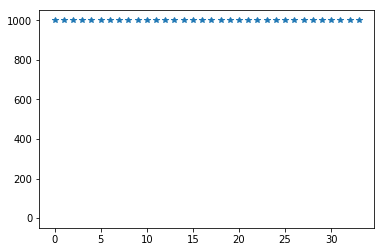

first 24 samples:


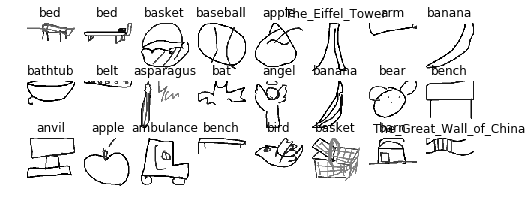

CPU times: user 9.6 s, sys: 1.45 s, total: 11 s
Wall time: 10.1 s


In [5]:
%time _ = test_nomp_datagen(34, 1_000, plot_on=True)

### Sanity test of multi-process data generator:

duration: 5.0847876612097025, total rows: 34_000, final batch index: 66, final x.shape: (208, 64, 64, 1), final y.shape: (208, 34)

class counts:


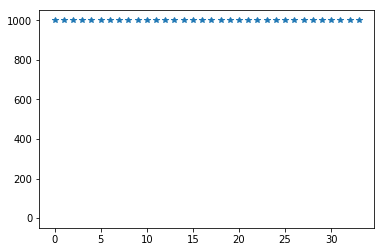

first 24 samples:


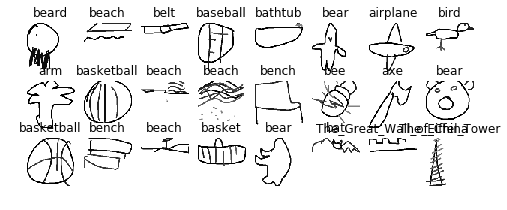

CPU times: user 1.9 s, sys: 1.26 s, total: 3.17 s
Wall time: 5.92 s


In [6]:
%time _ = test_mp_datagen(34, 1_000, cores=2, plot_on=True)

## Generate timing info for no multiprocessing, and then mp with more and more cores

STARTING NO MP TEST ...
    DONE: 1020000 rows in 236.02 seconds
STARTING MP TEST 1 CORE ...
    DONE: 1020000 rows in 245.33 seconds
STARTING MP TEST 2 CORE ...
    DONE: 1020000 rows in 129.39 seconds
STARTING MP TEST 3 CORE ...
    DONE: 1018864 rows in 90.73 seconds
STARTING MP TEST 4 CORE ...
    DONE: 1020000 rows in 79.01 seconds
STARTING MP TEST 5 CORE ...
    DONE: 1020000 rows in 73.49 seconds
STARTING MP TEST 6 CORE ...
    DONE: 1019370 rows in 73.13 seconds
STARTING MP TEST 7 CORE ...
    DONE: 1019199 rows in 73.48 seconds
STARTING MP TEST 8 CORE ...
    DONE: 1019460 rows in 76.78 seconds


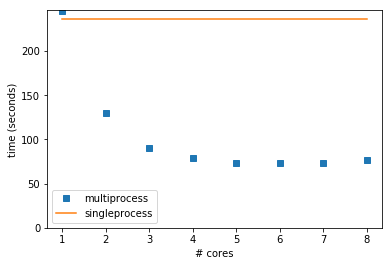

6
MAX SPEEDUP IS WITH 6 CORES, TOTAL SPEEDUP: 3.228


In [7]:
nclasses = 340
rowsperclass = 3_000
max_cores = 8
sleep_dur = 10

print('STARTING NO MP TEST ...')
duration0, rows, _, _, _, counts = test_nomp_datagen(nclasses, rowsperclass, plot_on=False)
print(f'    DONE: {rows} rows in {duration0:.2f} seconds')

durations = []
for i in range(max_cores):
    time.sleep(sleep_dur)
    print(f'STARTING MP TEST {i+1} CORE ...')
    duration, rows, _, _, _, counts = test_mp_datagen(nclasses, rowsperclass, i+1, plot_on=False)
    durations.append(duration)
    print(f'    DONE: {rows} rows in {duration:.2f} seconds')

plt.plot([i+1 for i in range(len(durations))], durations, 's', label='multiprocess')
plt.plot([1, len(durations)], [duration0, duration0], label='singleprocess')
plt.ylim((0, math.ceil(max(durations))))
plt.xticks([i+1 for i in range(len(durations))])
plt.ylabel('time (seconds)')
plt.xlabel('# cores')
plt.legend()
plt.show()
fastest_core = int(np.argmin(durations)+1)
print(fastest_core)
print(f'MAX SPEEDUP IS WITH {fastest_core} CORES, TOTAL SPEEDUP: {duration0/durations[fastest_core-1]:.3f}')

#### For good measure, draw histogram of last counts

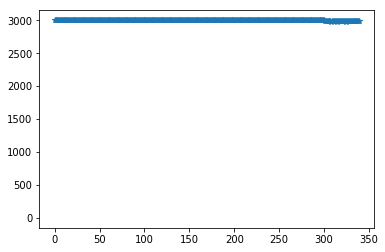

In [8]:
show_counter_histogram(counts)